In [66]:
import sys
import argparse
import numpy as np
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt

from keras.preprocessing import image
from keras.applications.xception import Xception, preprocess_input
from keras.applications import ResNet50
from keras.applications import InceptionV3
from keras.applications import VGG16
from keras.applications import VGG19
from keras.applications import imagenet_utils
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img

In [63]:
models = {
"vgg16": VGG16(weights='imagenet'),
"vgg19": VGG19(weights='imagenet'),
"inception": InceptionV3(weights='imagenet'),
"xception": Xception(weights='imagenet'),
"resnet": ResNet50(weights='imagenet')
}

In [155]:
used_models = ['vgg19', 'inception', 'resnet', 'xception']

In [162]:
def get_bottleneck(model_name, img):
    assert model_name in models.keys()
    model = models[model_name]

    target_size = (224, 224)
    
    if model_name in ['xception', 'inception']:
        preprocess = preprocess_input
    else:
        preprocess = imagenet_utils.preprocess_input
        
    if img.size != target_size:
        img = img.resize(target_size)
        
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess(x)
    
    return model.predict(x)


def predict(img, top_n=None):
    if not top_n:
        top_n = len(used_models)
    preds = {}
    for model in used_models:
        print('\n', model, ' predicts\n')
        b = get_bottleneck(model, img)
        p = imagenet_utils.decode_predictions(b, top=top_n)
        for _, label, prob in p[0]:
            print('%.2f%% %s'%(prob*100, label))
            if label not in preds.keys():
                preds[label] = prob
            else:
                preds[label] += prob
    s = np.sum([v for v in preds.values()])
    for k in preds.keys():
        preds[k] = preds[k] / s
    return sorted(preds.items(), key=lambda x: x[1], reverse=True)

def predict_from_url(url, target_size=target_size, top_n=3):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    preds = predict(img, target_size=target_size, top_n=3)
    return preds

def plot_preds(image=None, url=None, target_size=target_size, top_n=3):
    assert image != None or url !=  None
    if url:
        response = requests.get(url)
        image = Image.open(BytesIO(response.content))
    
    plt.imshow(image)
    plt.axis('off')
    
    preds =  predict(image, top_n)
    
    print(preds)
    
    plt.figure()
    order = list(reversed(range(len(preds))))
    
    labels = [p[0] for p in preds]
    bar_preds = [p[1] for p in preds]
    
    plt.barh(order, bar_preds, alpha=0.5)
    plt.yticks(order, labels)
    plt.xlabel('Probability')
    plt.xlim(0,1.01)
    plt.tight_layout()
    plt.show()



 vgg19  predicts

42.10% hair_spray
15.62% fur_coat
5.80% wig

 inception  predicts

39.42% saltshaker
35.78% hotdog
14.65% coffee_mug

 resnet  predicts

29.71% coffee_mug
20.17% paper_towel
14.53% toilet_tissue

 xception  predicts

88.51% coffee_mug
7.67% cup
3.50% eggnog
[('coffee_mug', 0.41855118), ('hair_spray', 0.13261573), ('saltshaker', 0.12416915), ('hotdog', 0.11271989), ('paper_towel', 0.06352778), ('fur_coat', 0.049198184), ('toilet_tissue', 0.04575721), ('cup', 0.024177272), ('wig', 0.018263824), ('eggnog', 0.011019722)]


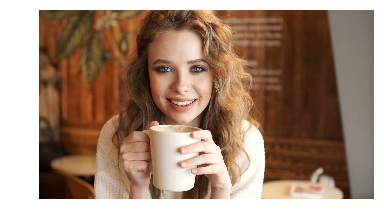

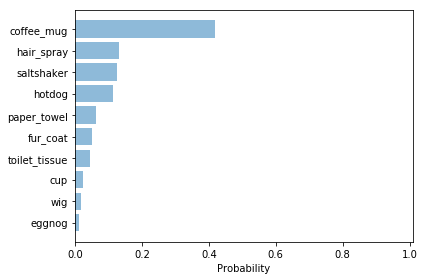

In [163]:
plot_preds(url='https://d2v9y0dukr6mq2.cloudfront.net/video/thumbnail/VKIq1onKeik8p806r/young-attractive-woman-smiling-to-camera-in-cafe-happy-girl-drinking-coffee-and-relaxing-in-cafe-smiling-and-looking-at-camera-beautiful-woman-with-cup-of-coffee-sitting-in-the-coffee-shop_bastfq4kg_thumbnail-full01.png')

In [ ]:
pretrained_model = InceptionV3(include_top=False, weights='imagenet', input_shape=(img_width, img_height, 3))
bottleneck_features_train_v2 = pretrained_model.predict(trainData.images,batch_size=16)